In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import gammaincinv, gammainc

In [2]:
from convenience_functions import *

# Problem 1: Simulating a single frame exposure

## [1a] Simulate a star with a Gaussian PSF

Before we can start thinking about coaddition and difference imaging, we need a (simulated) single frame exposure. For our purposes, let's think just about a single point source with a Gaussian profile.

First, write a function that returns a two-dimensional Gaussian for a grid of pixels (y,x):

In [13]:
def gaussian2d(x, y, normy, m, s):
    '''
    2D axisymmetric Gaussian profile, normalized such that the function integrates to unity.
    
    Parameters:
    -----------
    x, y : array-like
        Coordinate arrays
    m : array-like
        Center coordinates
    s : float
        Standard deviation (same for both x and y)
    '''
    xc = m[0]
    yc = m[1]

    x_ = xc-x 
    y_ = yc-y
    
    return 1/(2*np.pi*s**2)*np.exp((-(x_**2+y_**2)/(2*s**2)))

    # return your 2D Gaussian profile

Now, let's write a function that creates a mock exposure for a star of fixed brightness:

In [45]:
def take_exposure (exptime, star_count_rate=100., sky_count_rate=1., fwhm=20., imsize=128 ):
    '''
    Take a mock exposure for a specified exposure time (in seconds), given the total 
    count rate from a point source-like object and a sky brightness.
    
    Parameters:
    -----------
    exptime : float
        exposure time, in seconds
    star_count_rate : float
        total counts coming from a point-source-like object
    sky_count_rate : float
        total counts per pixel coming from the sky background
    fwhm : float
        Gaussian FWHM of the PSF, in pixels
    imsize : int
        exposure size (N=M=imsize)
    '''
    y,x = np.mgrid[:imsize+1,:imsize+1]
    xc = imsize//2
    yc = imsize//2



    psf_std = fwhm/2.355 # convert Gaussian FWHM to standard deviation
    star = gaussian2d(x,y, True,(xc,yc),psf_std) # stellar photon rate as a function of position
    total_count = exptime * star_count_rate # total stellar photons
    star *= total_count
    sky = exptime*sky_count_rate  # total sky photons
    signal = star+sky# total observed photons
    observed_signal = signal + np.random.normal(loc=signal, scale=np.sqrt(signal)) # draw from a noise profile where the standard deviation is the square root of signal
    return observed_signal

Now let's visualize what the exposure looks like at various exposure times.

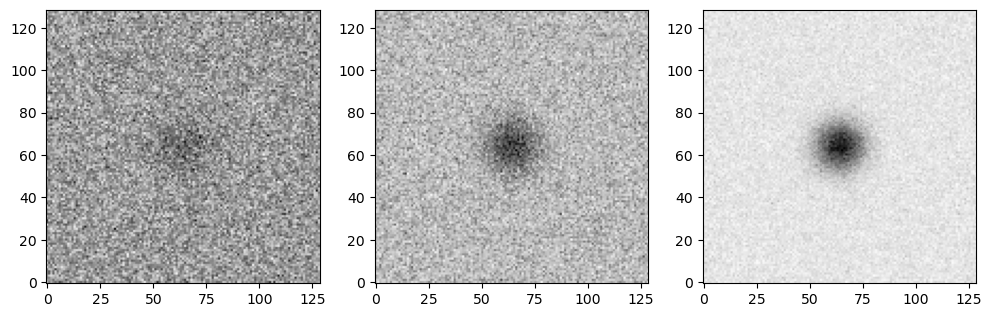

In [47]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))

for logtexp in np.arange(1,4):
    our_imshow(take_exposure(10.**logtexp), q=0., ax=axarr[logtexp-1])

## [1b] Recover the expected SNR scaling with exposure time

In the case where each exposure's noise and source properties are the same, we expect the SNR to scale as $\sqrt{t_{\rm exp}}$. Let's check that:

Text(0, 0.5, 'SNR')

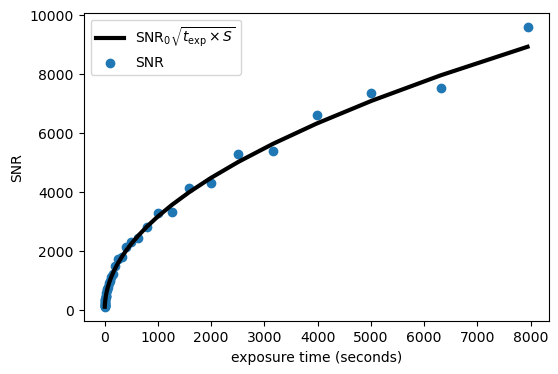

In [49]:
plt.figure(figsize=(6,4))
logtexp_array = np.arange(0., 4, 0.1)
star_count_rate = 100.

sky_sample = [take_exposure(10.**logtexp_)[0:20, 0:20].std() for logtexp_ in logtexp_array]# \\ let's make an empirical estimate of the noise in each exposure using the standard deviation in a blank patch of expsoure
star_counts =  star_count_rate*10.**logtexp_array# \\ and we know what the total counts from the star should be, given the exposure time.

plt.plot(
    10.**logtexp_array,
    star_counts[0]/sky_sample[0]*np.sqrt(10.**logtexp_array),
    # \\ expected scaling with exposure time here!
    label=r'SNR$_0\sqrt{t_{\rm exp}\times S}$',
    color='k',
    lw=3
)

plt.scatter(
    10.**logtexp_array,
    star_counts/sky_sample,
    # \\ empirical measure of SNR here!
    label='SNR',
)

plt.legend()
plt.xlabel('exposure time (seconds)')
plt.ylabel('SNR')

# Problem 2: Build a coadd from homogeneous data

## [2a] Build a mean-weighted coadd

Now that we can "take" single frame exposures, let's start making some coadds -- first, in the case where all exposure are taken under identical conditions.

In [52]:
texp = 10.
star_count_rate = 100.
exposures = np.array([ take_exposure(texp, star_count_rate) for _ in range(100) ])

In [55]:
mw_coadd = np.mean(exposures, axis=0)

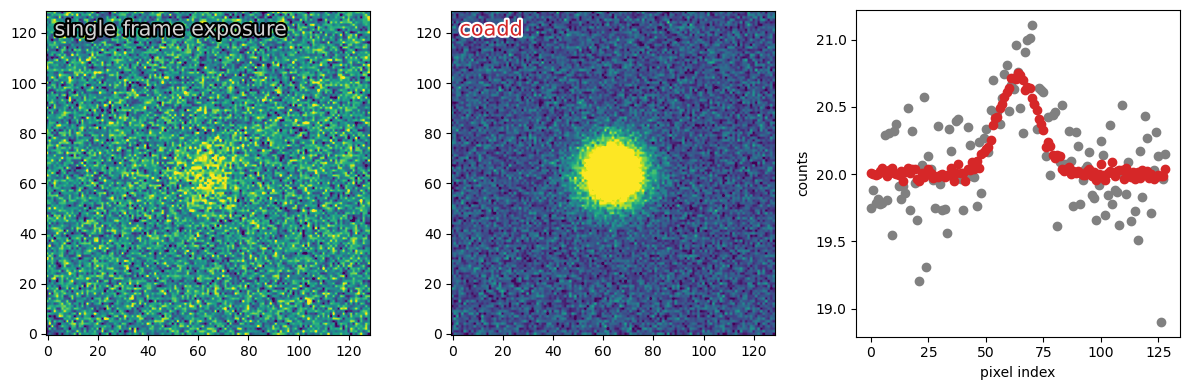

In [60]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(exposures[0], ax=axarr[0], cmap='viridis')
our_imshow(mw_coadd, ax=axarr[1], cmap='viridis')

px = np.arange(exposures[0].shape[1])
# \\ here, show the collapsed 1D profile of a single exposure and the mean coadd
axarr[2].scatter(
    px,
    np.mean(exposures[0], axis=1),
    # single exposure 1D profile here
    color='grey'
)
axarr[2].scatter(
    px,
    np.mean(mw_coadd, axis=1),
    color='tab:red'
)
axarr[2].set_xlabel('pixel index')
axarr[2].set_ylabel('counts')

our_text(0.025,0.975, 'single frame exposure', color='lightgrey', ax=axarr[0], fontsize=15, bordercolor='k', borderwidth=3)
our_text(0.025,0.975, 'coadd', color='tab:red', ax=axarr[1], fontsize=15, bordercolor='w', borderwidth=3)


plt.tight_layout ()

## [2b] Plot coadd depth as a function of the number of coadded images

For this set-up, we also expect the coadd depth (SNR) to scale as $\sqrt{D}$, where $D$ is the number of exposures going into the stack. Let's check that:

In [75]:
nstack = np.arange(1, 101)
stack_snr = np.zeros(nstack.shape)
texp = 10.
star_count_rate = 100.
star_counts = texp*star_count_rate # total counts expected from the point source (exposure time * count_rate)

for n in nstack:
    exposures = np.array([ take_exposure(texp, star_count_rate) for _ in range(n) ])
    coadd = np.mean(exposures, axis=0)#  make mean coadd
    sky_sample = coadd[0:20, 0:20].std() # empirical estimate of background uncertainty,would this be of single image or coadd?
    stack_snr[n-1] = np.mean(coadd)/sky_sample # record observed SNR

Text(0, 0.5, 'SNR')

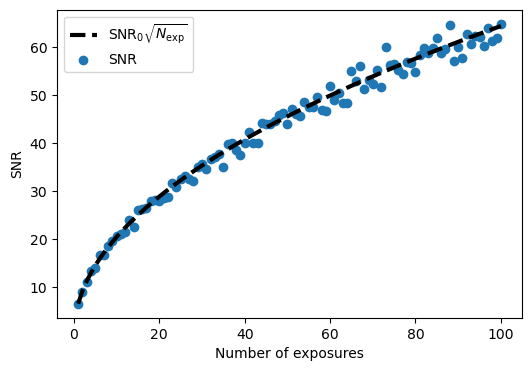

In [78]:
plt.figure(figsize=(6,4))

plt.plot(
    nstack,
    stack_snr[0]*np.sqrt(nstack),
    label=r'SNR$_0\sqrt{N_{\rm exp}}$',
    color='k',
    lw=3,
    ls='--'
)
plt.scatter(
    nstack,
    stack_snr,
    label='SNR',
)

plt.legend()
plt.xlabel('Number of exposures')
plt.ylabel('SNR')

# Problem 3: Build weighted coadds

In the real world, unfortunately, our observing conditions are not homogeneous -- therefore, we want a way to make coadds that take advantage of exposures taken under good conditions and downweight exposures taken under poor conditions. Let's consider two simple cases for making weighted coadds.

## [3a] Variable sky transparency

First let's consider a case where the sky background changes from one exposure to another. Now, we'll add another step (background subtraction) and construct an inverse variance-weighted coadd.

In [79]:
# \\ let's make two populations of exposures: one set taken under good conditions, the other under bad conditions
sky_bg = np.concatenate([np.random.uniform(1., 2., 50), np.random.uniform(50,100.,50)])
star_count_rate = 300.
exposures = [ take_exposure(10., star_count_rate, sky_count_rate) for sky_count_rate in sky_bg ]

In [87]:
weights

array([[1.80263526e-06, 1.82125809e-06, 1.81861061e-06, ...,
        1.80411884e-06, 1.81763207e-06, 1.83270856e-06],
       [1.81410649e-06, 1.80653879e-06, 1.80198370e-06, ...,
        1.81258225e-06, 1.83364009e-06, 1.80322626e-06],
       [1.82319685e-06, 1.81176138e-06, 1.81601299e-06, ...,
        1.80619958e-06, 1.82567014e-06, 1.82844087e-06],
       ...,
       [1.80566150e-06, 1.80917384e-06, 1.80788520e-06, ...,
        1.80731805e-06, 1.82093551e-06, 1.80317707e-06],
       [1.81755880e-06, 1.81333973e-06, 1.81386765e-06, ...,
        1.82741703e-06, 1.79703677e-06, 1.82350347e-06],
       [1.81857629e-06, 1.81116675e-06, 1.81888476e-06, ...,
        1.83070389e-06, 1.81497517e-06, 1.81134950e-06]])

In [97]:
bkg_variance =  sky_bg*10 # estimate of the per-exposure variance (should be a vector of length D)
weights = 1./bkg_variance# inverse-variance weights for the exposures

bkg_subtracted_exposures = exposures-sky_bg.reshape(-1, 1, 1)*10 # subtract off the mean per-expsoure background
unweighted_coadd = np.mean(bkg_subtracted_exposures, axis=0)
invvarweighted_coadd = np.sum(bkg_subtracted_exposures*weights.reshape(-1, 1, 1), axis=0)/np.sum(weights)

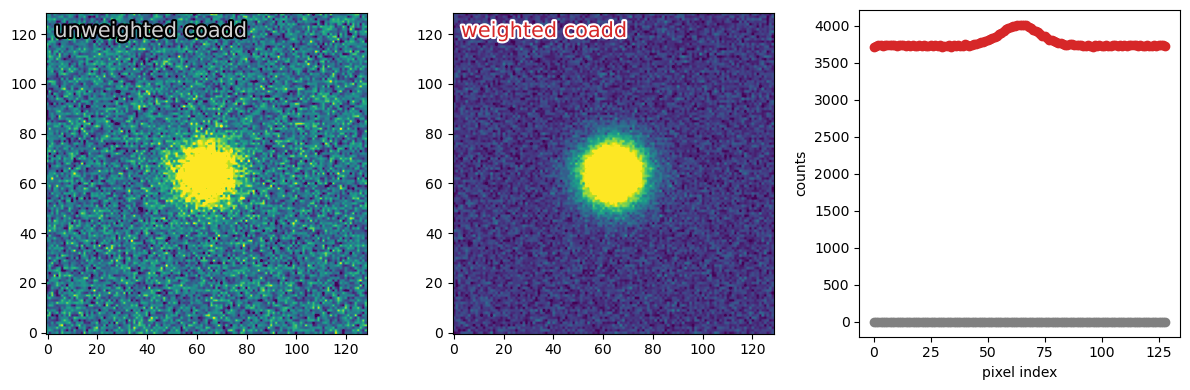

In [96]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(unweighted_coadd, ax=axarr[0], cmap='viridis')
our_imshow(invvarweighted_coadd, ax=axarr[1], cmap='viridis')

px = np.arange(exposures[0].shape[1])
axarr[2].scatter(px,np.sum(unweighted_coadd,axis=0), color='grey')
axarr[2].scatter(px,np.sum(invvarweighted_coadd,axis=0), color='tab:red')
axarr[2].set_xlabel('pixel index')
axarr[2].set_ylabel('counts')

our_text(0.025,0.975, 'unweighted coadd', color='lightgrey', ax=axarr[0], fontsize=15, bordercolor='k', borderwidth=3)
our_text(0.025,0.975, 'weighted coadd', color='tab:red', ax=axarr[1], fontsize=15, bordercolor='w', borderwidth=3)


plt.tight_layout ()

# Problem 4: Artifacts and read noise

Now let's take a brief dive into handling imaging artifacts! A common type of artifact is from cosmic rays, when charged particles strike the CCD and create a bright, highly linear pattern.

## [4a] Simulate single frame exposures with read noise and cosmic rays

In [ ]:
def add_cosmic_ray ( flux, x0, y0, m, dx, imsize ):
    y,x = np.mgrid[:imsize+1,:imsize+1]
    x_cr = np.arange(x0, x0+dx)
    y_cr = # flag pixels in a line described by y = m*(x-x0) + y0
    # \\ don't allow the line to run off the array
    img = # make image with CR hit
    return img
    
def take_exposure_p4 ( exptime, star_count_rate=100., sky_count_rate=1., fwhm=20., imsize=128, read_noise=10., cr_rate=0.01, cr_flux=100. ):
    '''
    The same as take_exposure, but now with cosmic rays hitting the detector probabilistically.
    '''
    y,x = np.mgrid[:imsize+1,:imsize+1]
    xc = imsize//2
    yc = imsize//2
    
    star = gaussian2d(# \\ add star and background, as for take_exposure

    ncr = # \\ add a randomly generated number of cCR hits based on cr_rate, which is defined as the
        # \\ average number of event per second
    cosmic_rays = np.zeros(star.shape)
    for _ in range(ncr):
        x0 = # draw x0
        y0 = # draw y0
        dx = # draw length
        m = # draw slope
        cosmic_rays += add_cosmic_ray(cr_flux, x0,y0,m,dx,imsize)
    
    signal = star + sky + cosmic_rays
   
    observed_signal = # simulate signal
    observed_signal_wreadnoise = # add read noise
    return observed_signal_wreadnoise

In [ ]:
fig, axarr = plt.subplots(1,2,figsize=(10,4))
our_imshow(take_exposure_p4(20., star_count_rate=100., ),  cmap='viridis', ax=axarr[0])
our_imshow(take_exposure_p4(600., star_count_rate=100., ), cmap='viridis',  ax=axarr[1])

our_text(0.025,0.975, 'short exposure', color='tab:red', ax=axarr[0], fontsize=15, bordercolor='w', borderwidth=3)
our_text(0.025,0.975, 'long exposure', color='tab:red', ax=axarr[1], fontsize=15, bordercolor='w', borderwidth=3)

So you might say -- let's just take a ton of short exposures! Then we'll have fewer cosmic rays to deal with, and more exposures to use to filter them out. At very short exposure times, however, you can become read noise dominated. To illustrate this, let's take two sky exposures of different exposure times, then compare their background-subtracted profiles.

In [ ]:
long_exp = take_exposure_p4(3600., star_count_rate=0., cr_rate=0.,read_noise=10.)
short_exp = take_exposure_p4(5., star_count_rate=0., cr_rate=0.,read_noise=10.)


In [ ]:
long_exp.std()

In [ ]:
short_exp.std()

## [4b] Cosmic ray detection on a single exposure

In this section we'll implement a simplified version of the cosmic ray detection used in HSC-SSP data processing, which itself is the precursor to the LSST science pipelines. We're going to put these cosmic rays in the vicinity of a very bright star to better illustrate the algorithm.

In [ ]:
from scipy import ndimage

In [ ]:
sky_count_rate = 1.
exptime = 50.
exposure_nosky = take_exposure_p4(50., star_count_rate=1e4, sky_count_rate=0., cr_flux=800, cr_rate=0.025)
sky_bg = np.random.normal(sky_count_rate*exptime, np.sqrt(sky_count_rate*exptime), exposure_nosky.shape)
exposure = exposure_nosky + sky_bg
our_imshow(exposure) # \\ verify visually that you have at least 1 CR in the image

In [ ]:
too_bright_factor = 6.
is_too_bright = # flag pixels above a factor of too_bright_factor of the sky background
our_imshow(is_too_bright.astype(float), cmap='viridis', q=0)

To find the cosmic rays morphologically, we'll use a simplified version of the algorithm originally implemented for SDSS. Essentially, we take the gradient of exposure in different directions and search for peaks that are sharper than what is allowed by the PSF.

In [ ]:
grad_v0 = # vertical gradient
grad_v1 = # vertical gradient in the opposite direction
grad_h0 = # horiziontal gradient
grad_h1 = # horizontal gradient in the opposite direction
gradients = [grad_v0, grad_v1, grad_h0, grad_h1]

std = # convert Gaussian FWHM to standard deviation
psf_diff = # estimate what the PSF fall-off would be at teh same distance as the scale over which the gradient was computed

too_sharp_factor = 6.
cr_masks = [ grad > (too_sharp_factor*exposure*psf_diff) for grad in gradients]
morphology_mask = np.sum(cr_masks,axis=0)

cosmic_ray_mask = is_too_bright & (morphology_mask > 1)

In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
our_imshow(exposure, ax=axarr[0])
axarr[1].imshow(cosmic_ray_mask, origin='lower')
our_imshow(np.where(cosmic_ray_mask, np.random.normal(0., sky_count_rate*exptime, cosmic_ray_mask.shape), exposure), ax=axarr[2])